## SSMI Ice data
### Cartopy quicklook

This notebook provides guidance to visualize SSMI data after it has been processed from raw binary data to csv data with columns of ice_concentration, latitude, and longitude.  It regrids the data to the users choice (default = 0.25x0.25 degree) by declaring the number of columns of latitude and longitude.

There is also timing components built in to see if and where the ingest/gridding/plotting can be spead up

__pyversion__==3.7   
__author__==S.Bell

In [1]:
import numpy as np
import datetime

import pandas as pd

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import timeit

In [2]:
df = pd.read_csv('data/nt_20170101_f18_nrt_n.csv')


In [3]:
df.describe()

,ice_conc,latitude,longitude
count,136192.000000,136192.000000,136192.000000
mean,12.664544,57.624520,17.489821
std,30.973567,12.239096,104.975745
min,0.000000,31.102670,-180.000000
25%,0.000000,47.900800,-70.346180
50%,0.000000,56.940085,6.666425
75%,0.000000,66.304733,115.033140
max,100.400000,89.836820,179.813980


## options for thinning data out

In [4]:
### set a range of lats and lons
# not advised as this messes with gridding assumptions later
#df.drop(df.loc[((df['latitude']<=45) | (df['latitude']>=75))].index, inplace=True)
#df.drop(df.loc[((df['longitude']<=-180) | (df['longitude']>=-150))].index, inplace=True)

### remove 0's by either dropping and making database smaller or by replacing with nans
# not advised for highly regional views as code may interpolate over these gaps oddly 
# . or zeros may be actual (polynas).  Global views may be ok and speed up though

#df.drop(df.loc[df['ice_conc']==0].index, inplace=True)
# or
df['ice_conc'][df['ice_conc']==0] = np.nan

In [5]:
df.describe()

,ice_conc,latitude,longitude
count,22405.000000,136192.000000,136192.000000
mean,76.983245,57.624520,17.489821
std,29.667363,12.239096,104.975745
min,0.400000,31.102670,-180.000000
25%,66.400000,47.900800,-70.346180
50%,91.600000,56.940085,6.666425
75%,98.400000,66.304733,115.033140
max,100.400000,89.836820,179.813980


In [6]:
#define the basic map projection information and figure size

def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(10.5, 10.5),
                           subplot_kw=dict(projection=projection))
    if projection == ccrs.PlateCarree():
        gl = ax.gridlines(draw_labels=True)
        gl.xlabels_top = gl.ylabels_right = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

#download land mask
# 50m is a good balance between dataset size and land feature resolution
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='1.0')

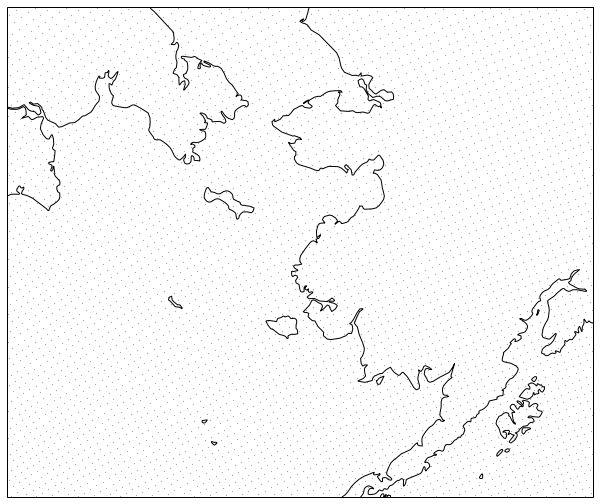

In [7]:
### Plot location of sample points for general BS region
extent = [180, 210, 55, 68]
projection=ccrs.LambertConformal(central_longitude=200.0)
transformation=ccrs.PlateCarree()
fig,ax = make_map(projection=projection)

ax.plot(df.longitude,df.latitude,'k.',markersize=.25,transform=transformation)
ax.add_feature(land_50m)
ax.coastlines(resolution='50m')
ax.set_extent(extent)

In [8]:
### Remapping the modes from the analysis
from scipy import interpolate
from matplotlib.mlab import griddata
import cmocean

#-- Now let's grid your data.
# First we'll make a regular grid to interpolate onto. This is equivalent to
# your call to `mgrid`, but it's broken down a bit to make it easier to
# understand. 

#The number of columns and rows can be directly linked to the grid resolution
#360 cols would be 1deg resolution... 180 cols would be 2deg resolution
#the more columns, the slower the gridding process but the smoother the plot.  Too
#many columns will lead to oversampling so .25x.25 is probably the highest I would go

numcols, numrows = 360*4, 90*4
xi = np.linspace(df.longitude.min(), df.longitude.max(), numcols)
yi = np.linspace(df.latitude.min(), df.latitude.max(), numrows)
xi, yi = np.meshgrid(xi, yi)

#-- Interpolate at the points in xi, yi
# "griddata" expects "raw" numpy arrays, so we'll pass in
# data.x.values instead of just the pandas series data.x

In [9]:
#%%timeit
# regridding data with 0's removed data
x, y, z = df.longitude.values, df.latitude.values, df.ice_conc.values
zi = interpolate.griddata((x, y),z, (xi, yi), method='linear')

### Global Map

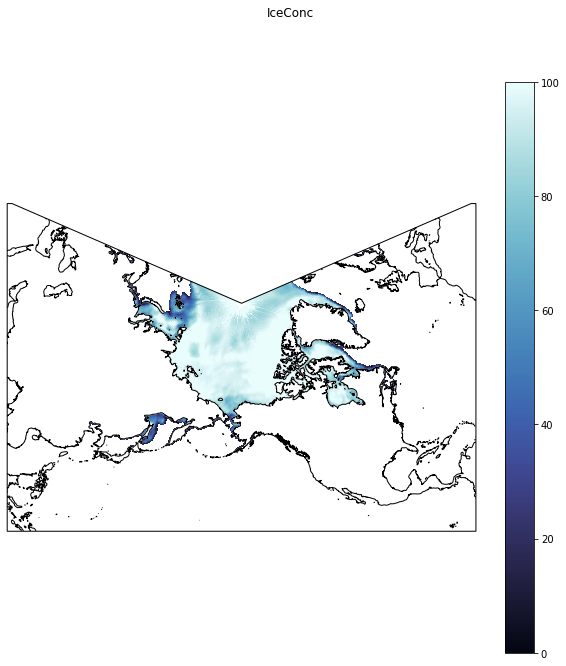

In [10]:
#%%timeit
projection=ccrs.LambertConformal(central_longitude=200.0)
transformation=ccrs.PlateCarree()
fig, ax = make_map(projection=projection)
#uncomment the following line if you want to see all the sample locations
#ax.plot(df.longitude.values,df.latitude.values,'k.',markersize=.25,transform=transformation)
cm=ax.pcolormesh(xi,yi,zi,transform=transformation,cmap=cmocean.cm.ice, vmin=0, vmax=100)
plt.colorbar(cm)
ax.add_feature(land_50m)
ax.coastlines(resolution='50m')
t = fig.suptitle('IceConc')

### Zoom to Alaska Region

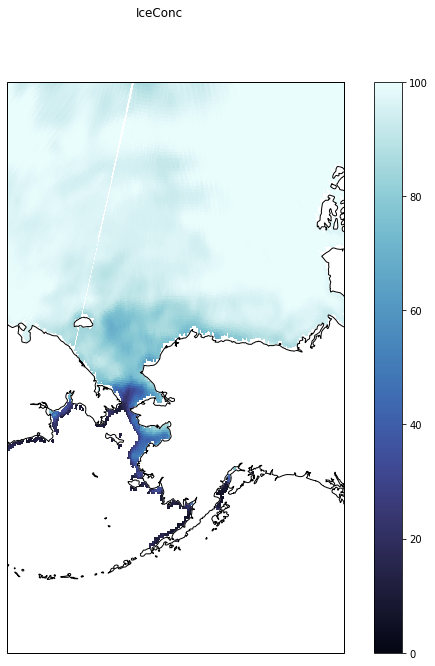

In [11]:
extent = [180, 220, 45, 85]
projection=ccrs.LambertConformal(central_longitude=200.0)
transformation=ccrs.PlateCarree()
fig, ax = make_map(projection=projection)

#ax.plot(df.longitude.values,df.latitude.values,'k.',markersize=.25,transform=transformation)
cm=ax.pcolormesh(xi,yi,zi,transform=transformation,cmap=cmocean.cm.ice, vmin=0, vmax=100)
plt.colorbar(cm)
ax.add_feature(land_50m)
ax.coastlines(resolution='50m')
ax.set_extent(extent)
t = fig.suptitle('IceConc')

### Zoom to Alaska Region and plot C2

lat = 164.105
lon = 71.230 

In [12]:
lat = 180-164.105+180
lon = 71.230 

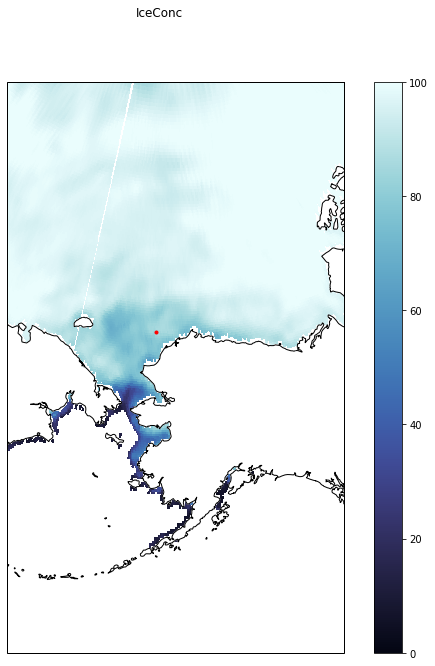

In [13]:
extent = [180, 220, 45, 85]
projection=ccrs.LambertConformal(central_longitude=200.0)
transformation=ccrs.PlateCarree()
fig, ax = make_map(projection=projection)

#ax.plot(df.longitude.values,df.latitude.values,'k.',markersize=.25,transform=transformation)
cm=ax.pcolormesh(xi,yi,zi,transform=transformation,cmap=cmocean.cm.ice, vmin=0, vmax=100)
ax.plot(lat,lon,'r.',transform=transformation)
plt.colorbar(cm)
ax.add_feature(land_50m)
ax.coastlines(resolution='50m')
ax.set_extent(extent)
t = fig.suptitle('IceConc')